<!-- Uncomment this badge to convert to PDF -->
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rinivarg/ReproRehab2024-Pod3/blob/main/Materials/Week%203/Week%203%20-%20Codebook.ipynb)

# Week 3: Clean and Merge Data

In Week 2, we combined individual raw data files into one comprehensive table. Now, we will merge this table with additional data, such as demographics, to prepare for analysis.

Currently, the table is in **long** format: time points are nested within each trial, and trials are nested within each subject (see figure for wide vs long formats).

This lesson will cover:
1. Basic data cleaning
2. Converting between long and wide data formats
3. Merging with a separate demographic table
4. Aggregating the data table
5. Using plots for data validation<br><br>

<!--for PDF>-->
<!-- 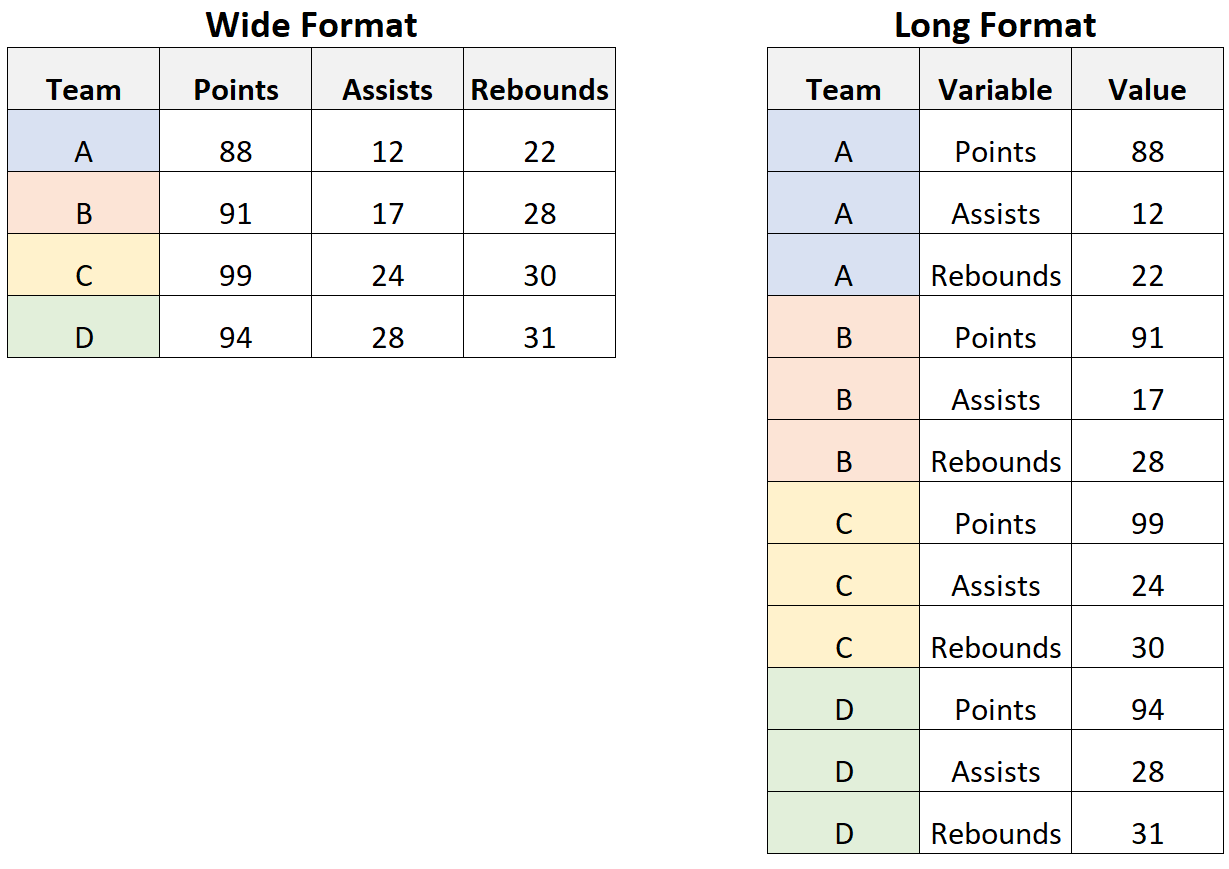 -->

<div style="float: right; margin-left: 20px;">
    <img src="./wide-long-data.png" alt="Long vs Wide Format Data - Courtesy of Statology" width="450" height="300">
    <br>
    <div style="text-align: right;"><small>Courtesy of <a href="https://www.statology.org" target="_blank">Statology</a></small></div>
</div>

## Clean the entire workspace

In [ ]:
rm(list=ls())

## Load required libraries

In [ ]:
ReqdLibs = c("here","ggplot2","ggthemes","dplyr","tidyr","corrplot","readxl","IRdisplay")
invisible(lapply(ReqdLibs, library, character.only = TRUE))

## Theme defaults

In [ ]:
thm = theme(
          strip.text.x=element_text(size=20,face="bold"),
          strip.text.y=element_text(size=20,face="bold"),
          legend.text=element_text(size=16,face="bold"),
          legend.position = "top",
          legend.title=element_text(size=16,face="bold"),
          title =element_text(size=14, face='bold'),
          text = element_text(colour = "black",size=18),
          plot.title = element_text(colour = "black",size = 22, face = "bold"),
          axis.ticks.length = unit(0.3,"cm"),
          axis.line = element_line(colour = "black",linewidth = 0.85),
          axis.ticks = element_line(colour = "black",linewidth = 0.85),
          axis.text = element_text(colour = "black",size=24),
          axis.title=element_text(size=25))

## Read data
I previously saved the parent data set as a `.csv` I am now reading it in here.

In [ ]:
data.all=read.csv("raw.data.all.csv")
head(data.all)
# data.all

,X,t,Rf,VT,VE,VO2,Sub,trial
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,2,18.51852,0.7548531,13.97876,408.6987,Sub1,rest
2,2,5,20.97902,0.5538989,11.62026,304.7868,Sub1,rest
3,3,8,18.23708,0.7058896,12.87337,347.7043,Sub1,rest
4,4,10,25.53191,0.7823950,19.97604,614.8135,Sub1,rest
5,5,13,21.97802,0.4957548,10.89571,253.6431,Sub1,rest
6,6,16,18.92744,0.7874953,14.90527,437.0967,Sub1,rest


## Start by visualizing
Plots across the time series by subject


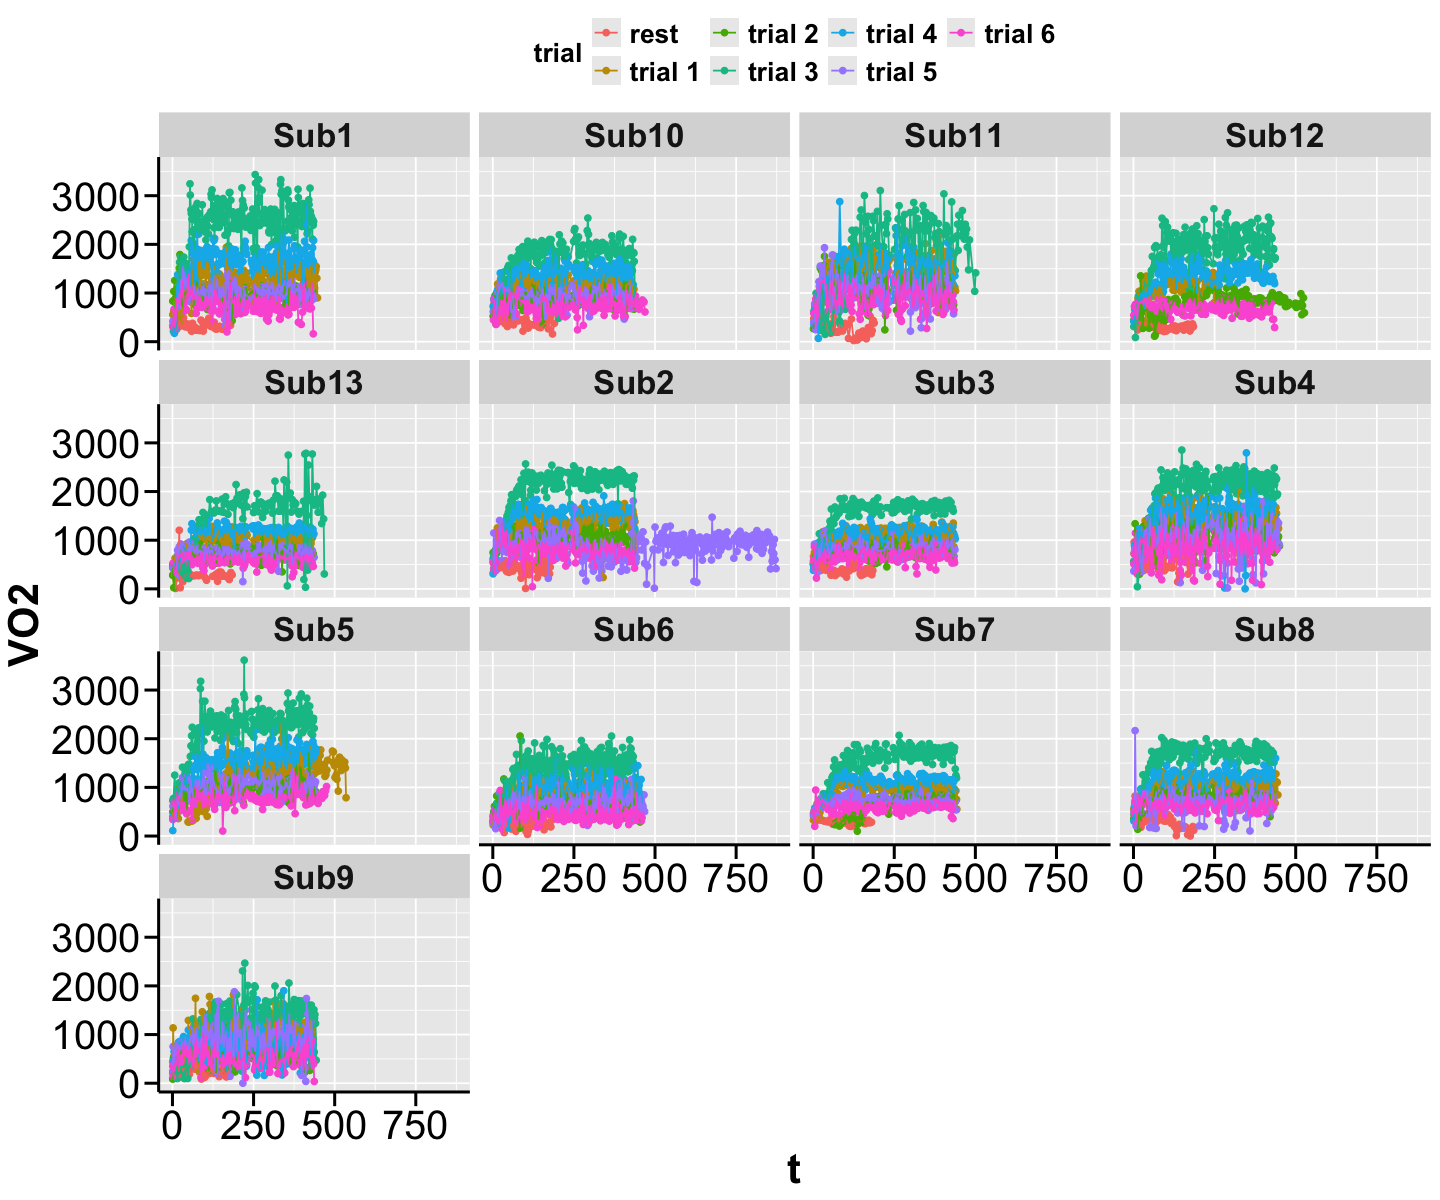

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 10)
ggplot(data.all,aes(x=t,y=VO2,color=trial))+
  geom_point()+
  geom_line()+
  facet_wrap(~Sub) + thm

## Some initial issues
### Issue 1: R naming convention
R still thinks my subjects are listed based on the value of the first integer. We need to change this first so it displays numerically.

In [ ]:
display_markdown("**Note that at present the `Sub` variable is of character class.** So, when you look for the levels of this variable, you see the output as being NULL, as character class does not have levels.**")
class(data.all$Sub)
levels(data.all$Sub)
display_markdown("**But I can convert it to a factor.** This factor now has levels, and I can set the ordering for this variable as I want them to be.**")
data.all$Sub=factor(data.all$Sub,levels = c("Sub1","Sub2","Sub3","Sub4",
                                            "Sub5", "Sub6","Sub7","Sub8",
                                            "Sub9","Sub10","Sub11","Sub12",
                                            "Sub13"))
#This is more desireable anyway because a factor class is treated as a categorical variable 
# when you run regressions or other statistical analyses.
class(data.all$Sub)
levels(data.all$Sub)

**Note that at present the `Sub` variable is of character class.** So, when you look for the levels of this variable, you see the output as being NULL, as character class does not have levels.**

[1] "character"

NULL

**But I can convert it to a factor.** This factor now has levels, and I can set the ordering for this variable as I want them to be.**

[1] "factor"

[1] "Sub1"  "Sub2"  "Sub3"  "Sub4"  "Sub5"  "Sub6"  "Sub7"  "Sub8"  "Sub9" 
[10] "Sub10" "Sub11" "Sub12" "Sub13"

### visualize again after fixing this issue

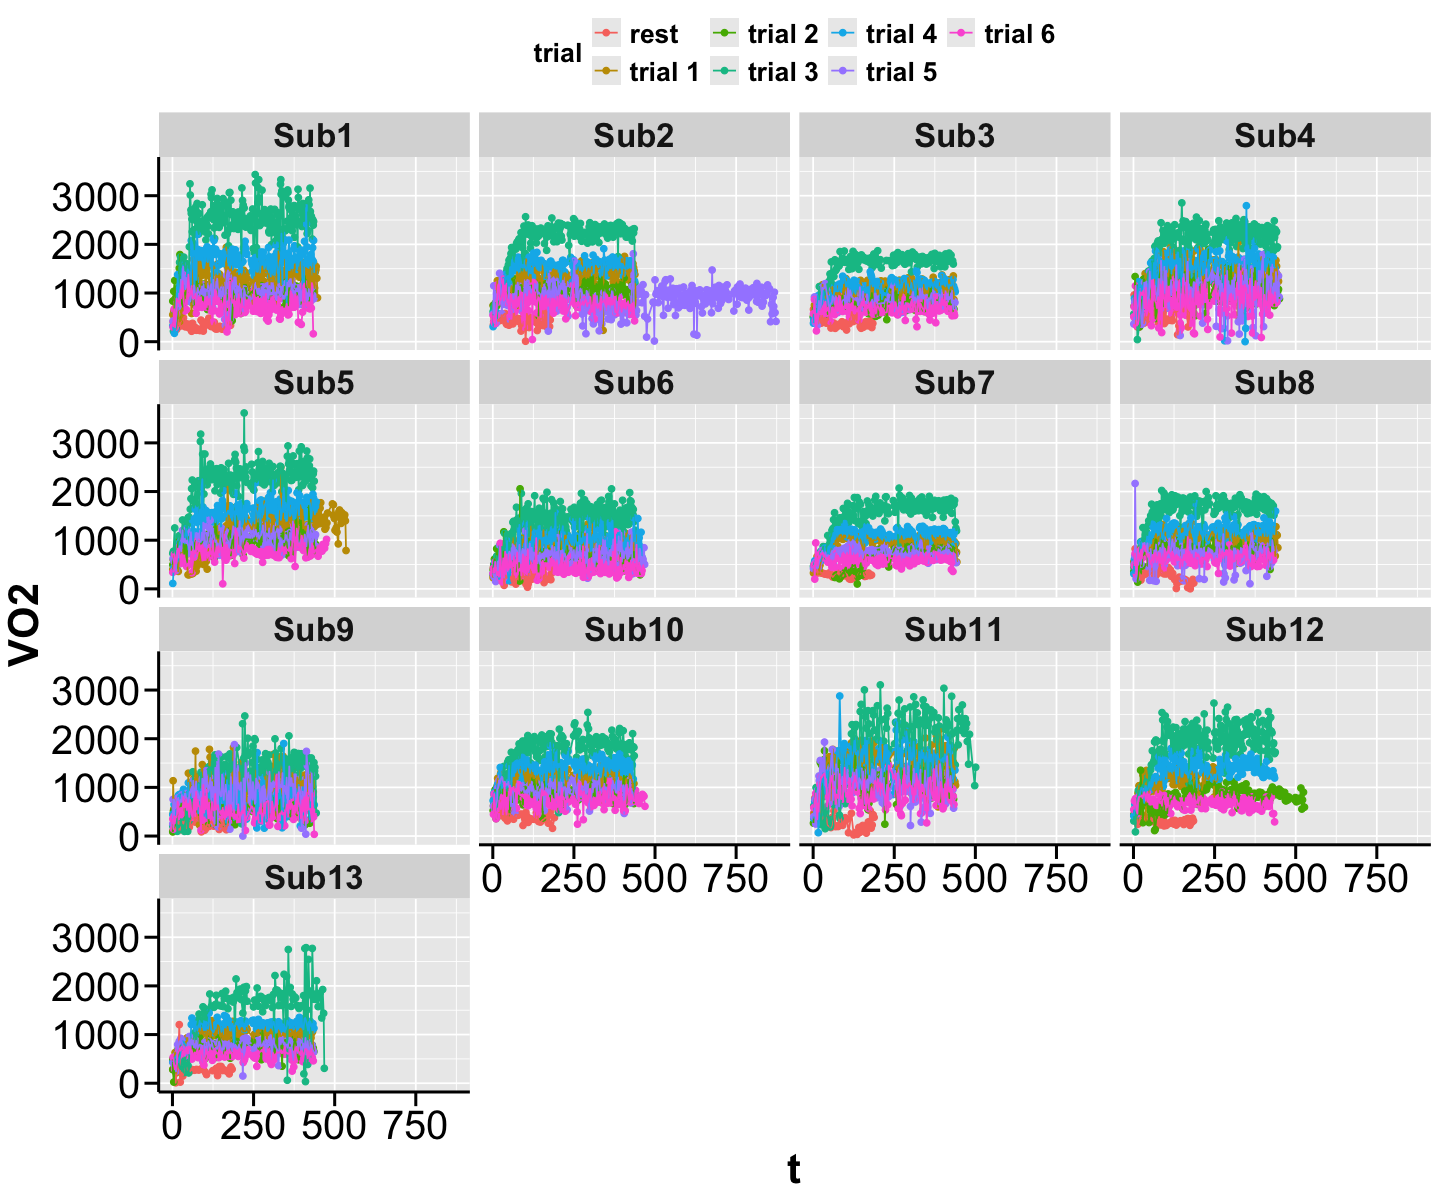

In [ ]:
#Fixed
ggplot(data.all,aes(x=t,y=VO2,color=trial))+
  geom_point()+
  geom_line()+
  facet_wrap(~Sub) + thm

### Issue 2: Inconsistent number of points across trials
Sub 2 took way more time than everyone else on trial 5. I am going to assume
that doesn't warrant throwing that subjects data out, and instead I will just
trim the excess away.<br>

To do that, let's first see how much of the extra to remove. Let's look at how long all subject's trial 5 was. The function aggregate will provide some summary stat based on how I want the dataset aggregated. Here I just want the max time for trial 5 across all subjects. To reduce the output I just index the data.all to only include trial 5. Looks like Sub 2 did 873 seconds, and everyone else did ~440

In [ ]:
aggregate(t~Sub,data.all[data.all$trial=="trial 5",],max)  #%>% mutate(a = median(.$t))

Sub,t
<fct>,<int>
Sub1,436
Sub2,873
Sub3,437
Sub4,449
Sub5,443
Sub6,468
Sub7,441
Sub8,433
Sub9,433


### trim the data
I am going to remove all t for Sub 2 greater than 440. I am going to use a method called negation `!()`. Here I put in a bunch of boolean arguments into `()` and then preceed it with a `!`. This removes all the rows in my dataset that match these conditions.

Note that if I removed the !() it would only return the trial 5, for Sub2 with t > 440

In [ ]:
display_markdown("**using base R**")
# using base R
data.all2 = data.all[!(data.all$trial=="trial 5" & data.all$Sub=="Sub2" & data.all$t>440),]
head(data.all2)

display_markdown("**using dplyr**")
# using dplyr
data.all2 <- 
data.all %>%
  filter(!(trial=="trial 5" & Sub=="Sub2" & t>440))
head(data.all2)


**using base R**

,X,t,Rf,VT,VE,VO2,Sub,trial
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,1,2,18.51852,0.7548531,13.97876,408.6987,Sub1,rest
2,2,5,20.97902,0.5538989,11.62026,304.7868,Sub1,rest
3,3,8,18.23708,0.7058896,12.87337,347.7043,Sub1,rest
4,4,10,25.53191,0.7823950,19.97604,614.8135,Sub1,rest
5,5,13,21.97802,0.4957548,10.89571,253.6431,Sub1,rest
6,6,16,18.92744,0.7874953,14.90527,437.0967,Sub1,rest


**using dplyr**

,X,t,Rf,VT,VE,VO2,Sub,trial
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,1,2,18.51852,0.7548531,13.97876,408.6987,Sub1,rest
2,2,5,20.97902,0.5538989,11.62026,304.7868,Sub1,rest
3,3,8,18.23708,0.7058896,12.87337,347.7043,Sub1,rest
4,4,10,25.53191,0.7823950,19.97604,614.8135,Sub1,rest
5,5,13,21.97802,0.4957548,10.89571,253.6431,Sub1,rest
6,6,16,18.92744,0.7874953,14.90527,437.0967,Sub1,rest


### visualize again after fixing the issue

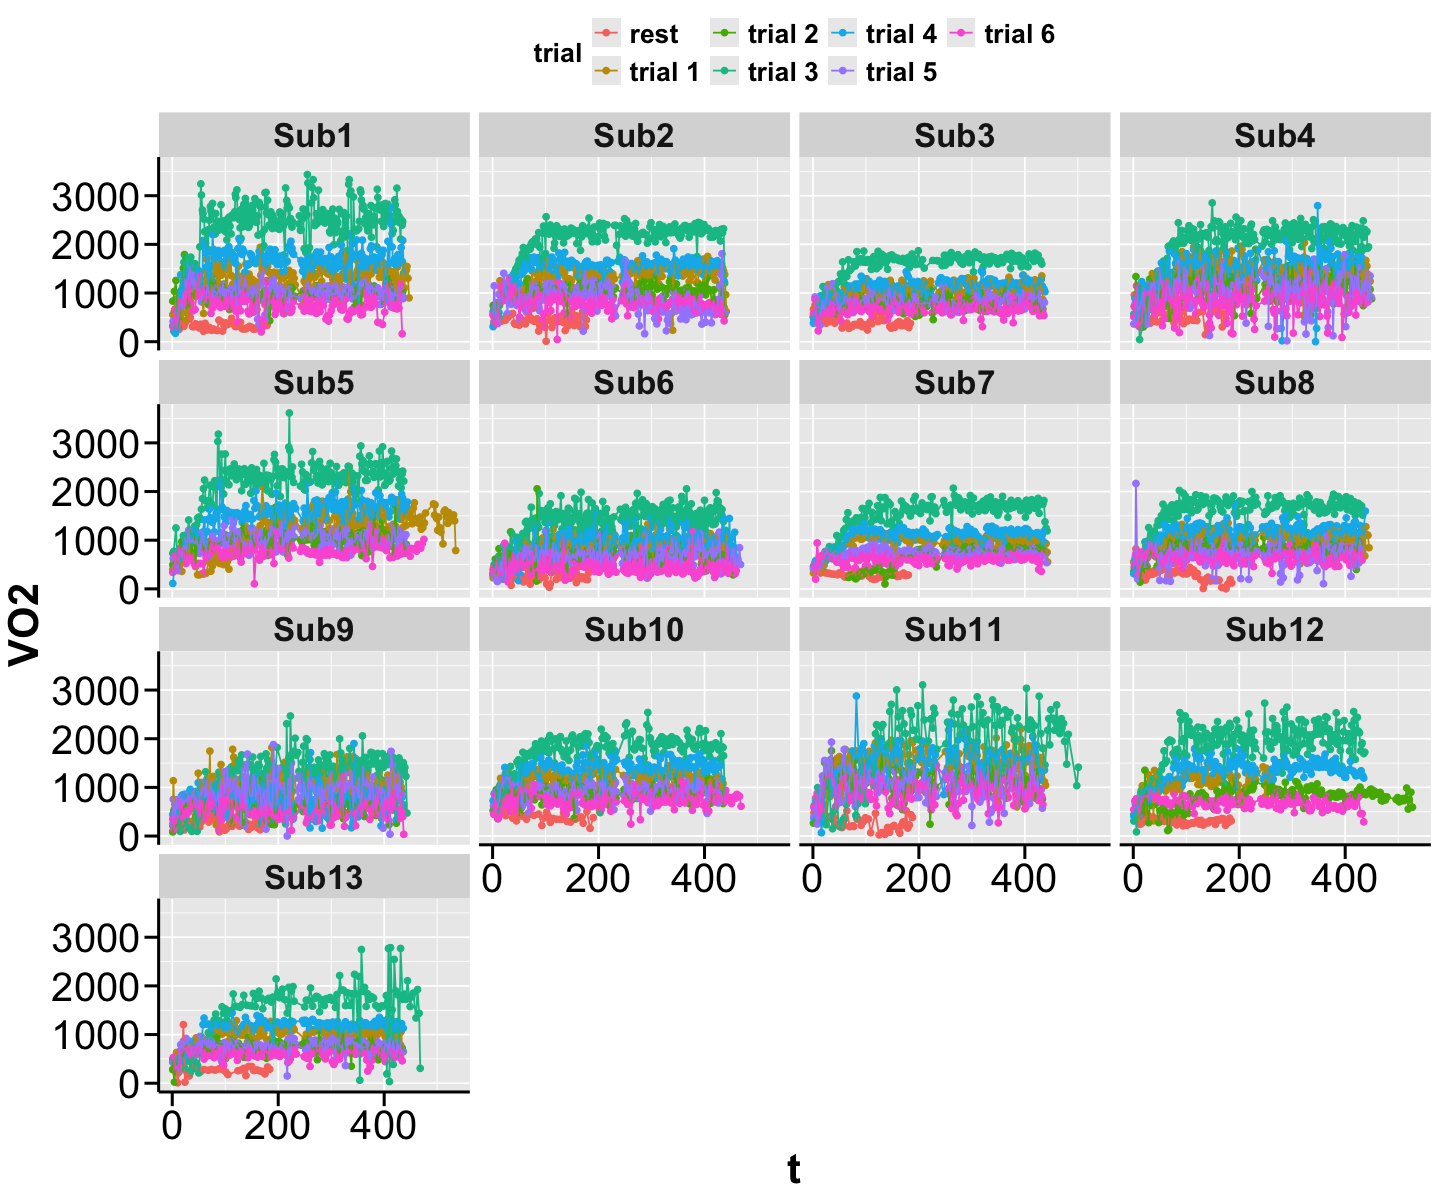

In [ ]:
#Fixed
ggplot(data.all2,aes(x=t,y=VO2,color=trial))+
  geom_point()+
  geom_line()+
  facet_wrap(~Sub) + thm

#I could repeat this process again but let's move on.

## Pivoting: Converting data tables from long to wide format and vice versa

Now I am going to convert the data from long to wide format using the `pivot` functions in the tidyr library. This can be useful if I want to look at correlations between my behavioral variables.<br>
There are various situations where one format is preferable to others. **Note**: when in doubt, remember the tidy data format; each row is an independent observation and each column is a variable of interest. You should <u>never stack numbers along rows of a column that do not share the same units</u>.


### First, I am going to create an aggregate of the data
This creates a summarized data set across our 4 outcome variables average across time for each subject for each trial

In [ ]:
# using base R: 
display_markdown("**using base R**")
data.agg = aggregate(cbind(VO2,Rf,VE,VT) ~ trial + Sub, data.all2, mean)
head(data.agg)

# using dplyr:
display_markdown("**using dplyr**")
data.all2 %>%
    group_by(Sub, trial) %>%
    summarize(across(c(VO2, Rf, VE, VT), mean), .groups = "drop") -> data.agg
head(data.agg)
dim(data.agg)

**using base R**

,trial,Sub,VO2,Rf,VE,VT
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,rest,Sub1,340.4917,18.01353,12.45402,0.6969207
2,trial 1,Sub1,1303.5808,30.71848,30.52191,0.9942740
3,trial 2,Sub1,995.2381,26.19241,26.57332,1.0231692
4,trial 3,Sub1,2406.8231,39.76738,54.23449,1.3645677
5,trial 4,Sub1,1630.8077,32.55784,39.19033,1.2078367
6,trial 5,Sub1,996.5392,31.26921,25.57869,0.8297402


**using dplyr**

Sub,trial,VO2,Rf,VE,VT
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Sub1,rest,340.4917,18.01353,12.45402,0.6969207
Sub1,trial 1,1303.5808,30.71848,30.52191,0.9942740
Sub1,trial 2,995.2381,26.19241,26.57332,1.0231692
Sub1,trial 3,2406.8231,39.76738,54.23449,1.3645677
Sub1,trial 4,1630.8077,32.55784,39.19033,1.2078367
Sub1,trial 5,996.5392,31.26921,25.57869,0.8297402


[1] 89  6

### Next, let's "pivot" the data frame to a wide format
along the trial variable

In [ ]:
# Using the pivot_wider function from tidyr to create a new variable for each trial
data.agg.wide = pivot_wider(data.agg,names_from = trial,
                       values_from = VO2:VT,id_cols = Sub)

head(data.agg.wide)

Sub,VO2_rest,VO2_trial 1,VO2_trial 2,VO2_trial 3,VO2_trial 4,VO2_trial 5,VO2_trial 6,Rf_rest,Rf_trial 1,⋯,VE_trial 4,VE_trial 5,VE_trial 6,VT_rest,VT_trial 1,VT_trial 2,VT_trial 3,VT_trial 4,VT_trial 5,VT_trial 6
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sub1,340.4917,1303.5808,995.2381,2406.823,1630.8077,996.5392,756.5212,18.01353,30.71848,⋯,39.19033,25.57869,20.74203,0.6969207,0.9942740,1.0231692,1.3645677,1.2078367,0.8297402,0.8060058
Sub2,425.3084,1323.6394,1020.4479,2078.080,1496.5663,871.1348,784.9221,21.07507,28.02262,⋯,37.08910,26.07491,22.70974,0.8089414,1.2167374,1.0958693,1.7699935,1.3759318,0.9135077,0.9194676
Sub3,420.5079,1051.5241,784.2673,1573.928,1092.0823,826.5741,681.2089,17.44000,26.03514,⋯,27.49903,20.36638,18.86121,0.7255701,1.0417310,0.8991307,1.5092272,1.1299703,0.9372364,0.8014394
Sub4,551.1862,1386.2685,1138.2881,2072.835,1515.1282,1045.7354,821.3389,16.25048,26.97537,⋯,35.25748,28.51496,21.92317,0.9334412,1.2122749,1.0908804,1.4853147,1.3167080,0.9421616,0.9211316
Sub5,NA,1240.8729,1010.5470,2211.938,1523.3187,1021.5176,760.8050,NA,24.72447,⋯,35.07922,23.85120,18.64142,NA,1.1248736,1.0232752,1.5137830,1.2792364,0.9930049,0.8899951
Sub6,260.5606,859.7148,672.5981,1380.404,905.8012,668.0126,443.6667,23.89754,35.88477,⋯,26.38974,21.44410,15.12465,0.4345420,0.6960416,0.6004941,0.8748827,0.7358324,0.5451516,0.4433895


### Visualizing correlations across trials using the wider format data

NULL

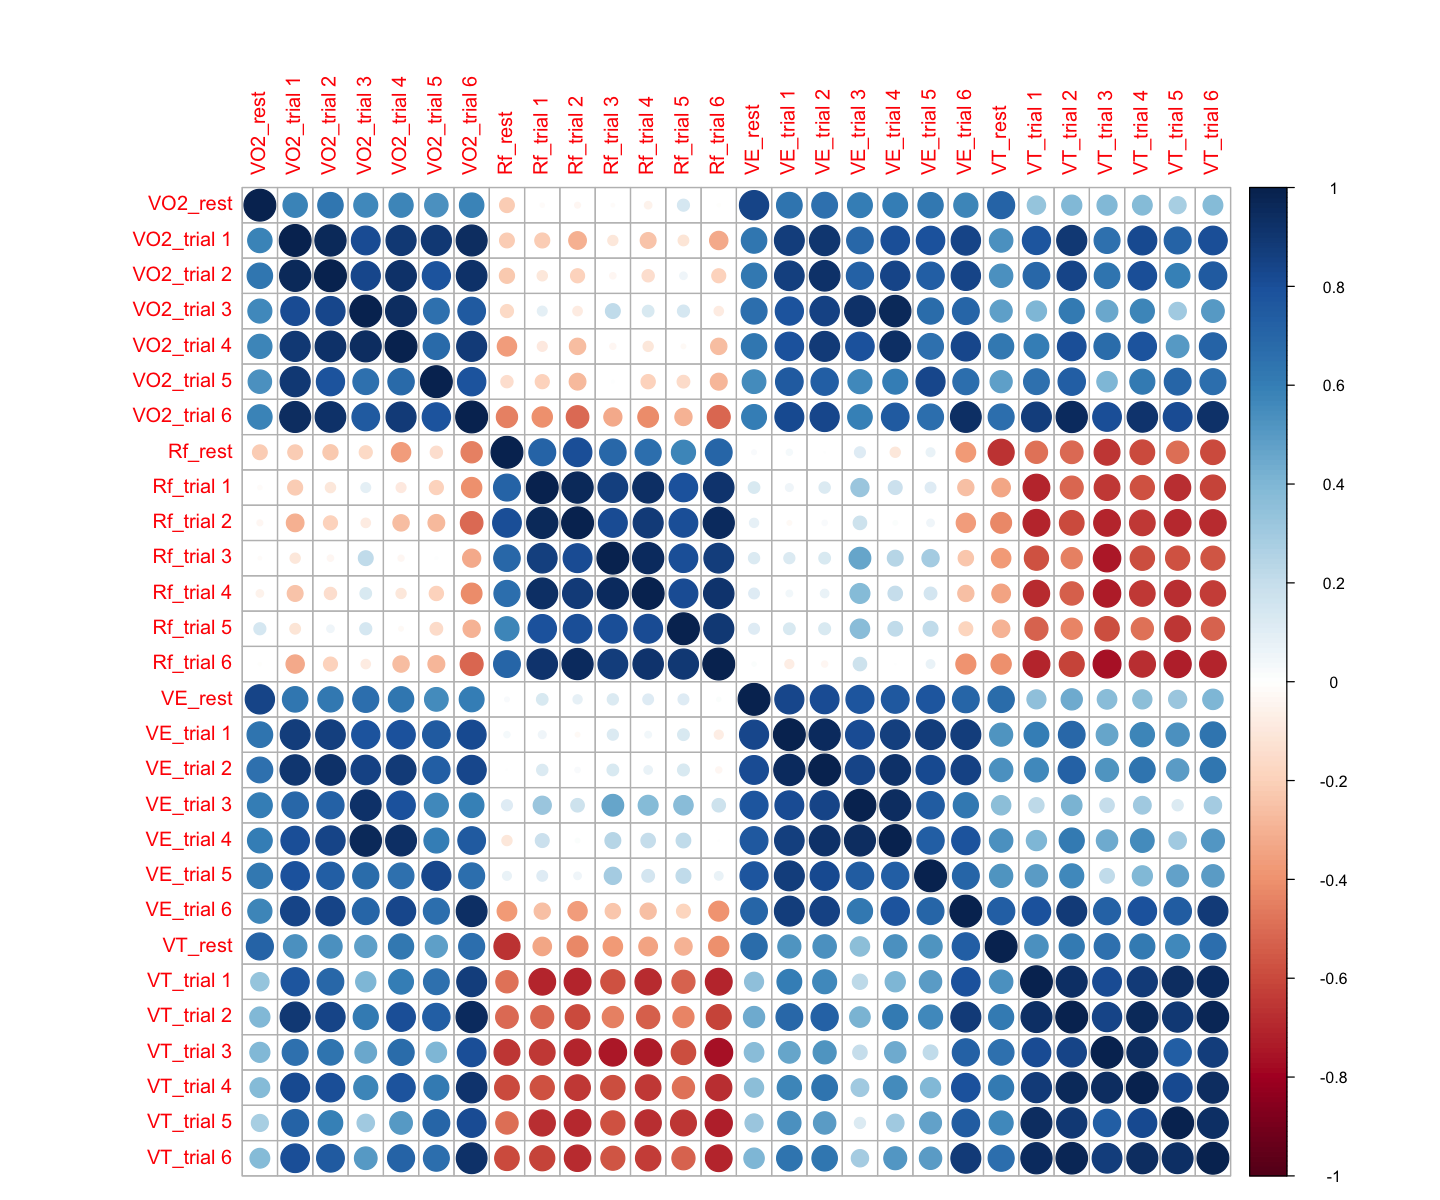

In [ ]:
#create a correlation matrix with only comlete observations,
#Can only include numeric variables.
cmat=cor(data.agg.wide[,-1],use="complete.obs")

#Let's visualize the correlations.
corrplot(cmat) + theme_minimal() + thm

### Now, let's pivot back to the long format

In [ ]:
# Now let's convert our wide dataset back to long, just for fun.
data.agg.long <- pivot_longer(data.agg.wide,
                           cols = VO2_rest:`VT_trial 6`,
                           names_to = c(".value", "trial"),
                           names_sep = "_")
head(data.agg.long)

Sub,trial,VO2,Rf,VE,VT
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Sub1,rest,340.4917,18.01353,12.45402,0.6969207
Sub1,trial 1,1303.5808,30.71848,30.52191,0.9942740
Sub1,trial 2,995.2381,26.19241,26.57332,1.0231692
Sub1,trial 3,2406.8231,39.76738,54.23449,1.3645677
Sub1,trial 4,1630.8077,32.55784,39.19033,1.2078367
Sub1,trial 5,996.5392,31.26921,25.57869,0.8297402


## Merge with Demographics
Now that we have our data in a variety of formats we can now merge it with the demographic data.

In [ ]:
demo = read_excel("SubjectInfo.xlsx")
head(demo)

Subject No,Age,Reported Weight (kg),Reported Length (cm),Gender,Level Slow,Level Walk,Weight from force plates(kg)
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Sub1,26,86,185,M,885.5529,891.5307,90.57511
Sub2,28,77,178,F,767.7686,760.2377,77.88004
Sub3,21,52,170,M,530.6408,558.2018,55.49656
Sub4,25,73,168,M,NA,NA,NA
Sub5,34,86,173,M,878.6303,898.5188,90.57845
Sub6,19,54,160,F,553.4936,558.2845,56.66555


### merging the demo data to the aggregate data in the long format
Note that if the names of the reference variable (in this case subject ID) by which the two data frames are being merged are different then we have to call that explicitly.

In [ ]:
demo.data = merge(data.agg,demo,by.x = "Sub",by.y = "Subject No")
head(demo.data)

,Sub,trial,VO2,Rf,VE,VT,Age,Reported Weight (kg),Reported Length (cm),Gender,Level Slow,Level Walk,Weight from force plates(kg)
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,Sub1,rest,340.4917,18.01353,12.45402,0.6969207,26,86,185,M,885.5529,891.5307,90.57511
2,Sub1,trial 1,1303.5808,30.71848,30.52191,0.9942740,26,86,185,M,885.5529,891.5307,90.57511
3,Sub1,trial 2,995.2381,26.19241,26.57332,1.0231692,26,86,185,M,885.5529,891.5307,90.57511
4,Sub1,trial 3,2406.8231,39.76738,54.23449,1.3645677,26,86,185,M,885.5529,891.5307,90.57511
5,Sub1,trial 4,1630.8077,32.55784,39.19033,1.2078367,26,86,185,M,885.5529,891.5307,90.57511
6,Sub1,trial 5,996.5392,31.26921,25.57869,0.8297402,26,86,185,M,885.5529,891.5307,90.57511


### merging the demo data to the aggregate data in the wide format
See how the demographic variables in the table above repeat themselves over the different trials for each subject. This is because the `merge()` function identifies that each subject has only 1 number for weight or height but it has 7 rows of trial-wise data. So it repeats them over these 7 rows. What type of table would be ideal to merge with the demographic table?...where all of the trials for one subject are in a single row? The wide format!<br><br>

So, let's combine the demographic data with our previously created `data.agg.wide` dataframe.

In [ ]:
demo.data_wide = merge(data.agg.wide,demo,by.x = "Sub",by.y = "Subject No")
head(demo.data_wide)

,Sub,VO2_rest,VO2_trial 1,VO2_trial 2,VO2_trial 3,VO2_trial 4,VO2_trial 5,VO2_trial 6,Rf_rest,Rf_trial 1,⋯,VT_trial 4,VT_trial 5,VT_trial 6,Age,Reported Weight (kg),Reported Length (cm),Gender,Level Slow,Level Walk,Weight from force plates(kg)
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,Sub1,340.4917,1303.5808,995.2381,2406.823,1630.808,996.5392,756.5212,18.01353,30.71848,⋯,1.207837,0.8297402,0.8060058,26,86,185,M,885.5529,891.5307,90.57511
2,Sub10,430.0402,1181.1066,879.9850,1776.831,1350.246,929.5444,757.7739,14.16538,27.57826,⋯,1.251704,1.0635515,0.9942577,20,66,170,F,673.0147,675.1750,68.71507
3,Sub11,299.8132,1441.6617,1114.7714,1836.072,1502.942,1039.9077,915.1615,14.92171,21.74782,⋯,1.717326,1.3595766,1.2843791,20,76,188,M,783.6798,783.4256,79.87285
4,Sub12,318.8275,1100.9149,795.6721,1901.475,1332.632,NA,682.6801,18.18356,25.38323,⋯,1.216100,NA,0.9408977,33,70,178,M,715.1903,715.5865,72.92440
5,Sub13,289.7562,986.0555,732.9015,1458.078,1126.762,733.7484,597.8291,12.50729,23.70696,⋯,1.284941,0.7967237,0.7696049,21,56,169,F,661.9267,658.0335,67.27626
6,Sub2,425.3084,1323.6394,1020.4479,2078.080,1496.566,871.1348,784.9221,21.07507,28.02262,⋯,1.375932,0.9135077,0.9194676,28,77,178,F,767.7686,760.2377,77.88004


### now let's plot one of the demographic variables against one of the metabolic variables
We're plotting weight against VO2 from trial 3. You see how a wide data format can be useful for correlations and scatterplots of this type where 1 row has data unique to 1 subject.

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


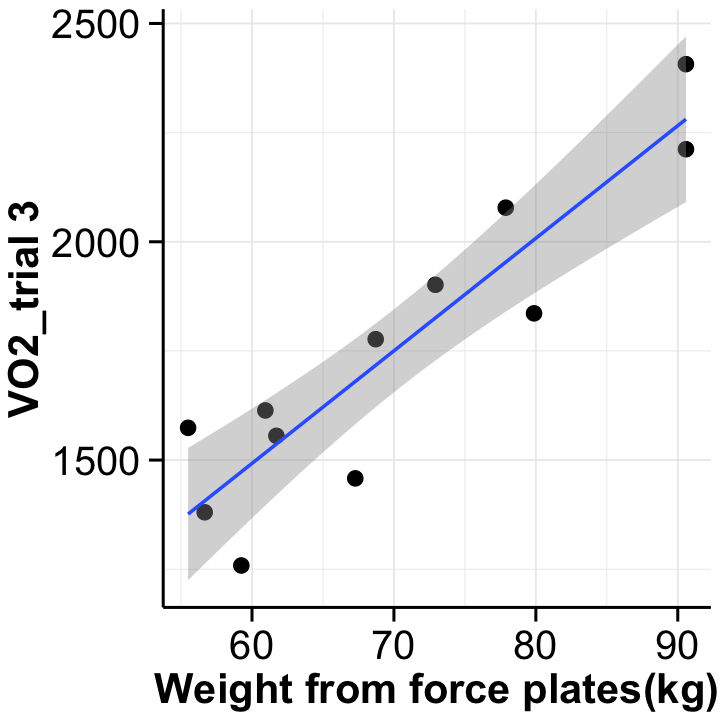

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(data = demo.data_wide, aes(x = `Weight from force plates(kg)`,y = `VO2_trial 3`)) + 
geom_point(size = 4) + geom_smooth(method = "lm", formula = y~x) + theme_minimal() + thm

### Let's pivot the aggregate data again to look at all variables in one column


In [ ]:
demo.data.var.long = pivot_longer(demo.data,
                               cols = VO2:VT,
                               names_to = "Variable",
                               values_to = "Value")

head(demo.data.var.long)
dim(demo.data.var.long)

Sub,trial,Age,Reported Weight (kg),Reported Length (cm),Gender,Level Slow,Level Walk,Weight from force plates(kg),Variable,Value
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Sub1,rest,26,86,185,M,885.5529,891.5307,90.57511,VO2,340.4917005
Sub1,rest,26,86,185,M,885.5529,891.5307,90.57511,Rf,18.0135254
Sub1,rest,26,86,185,M,885.5529,891.5307,90.57511,VE,12.4540164
Sub1,rest,26,86,185,M,885.5529,891.5307,90.57511,VT,0.6969207
Sub1,trial 1,26,86,185,M,885.5529,891.5307,90.57511,VO2,1303.5807786
Sub1,trial 1,26,86,185,M,885.5529,891.5307,90.57511,Rf,30.7184834


[1] 356  11

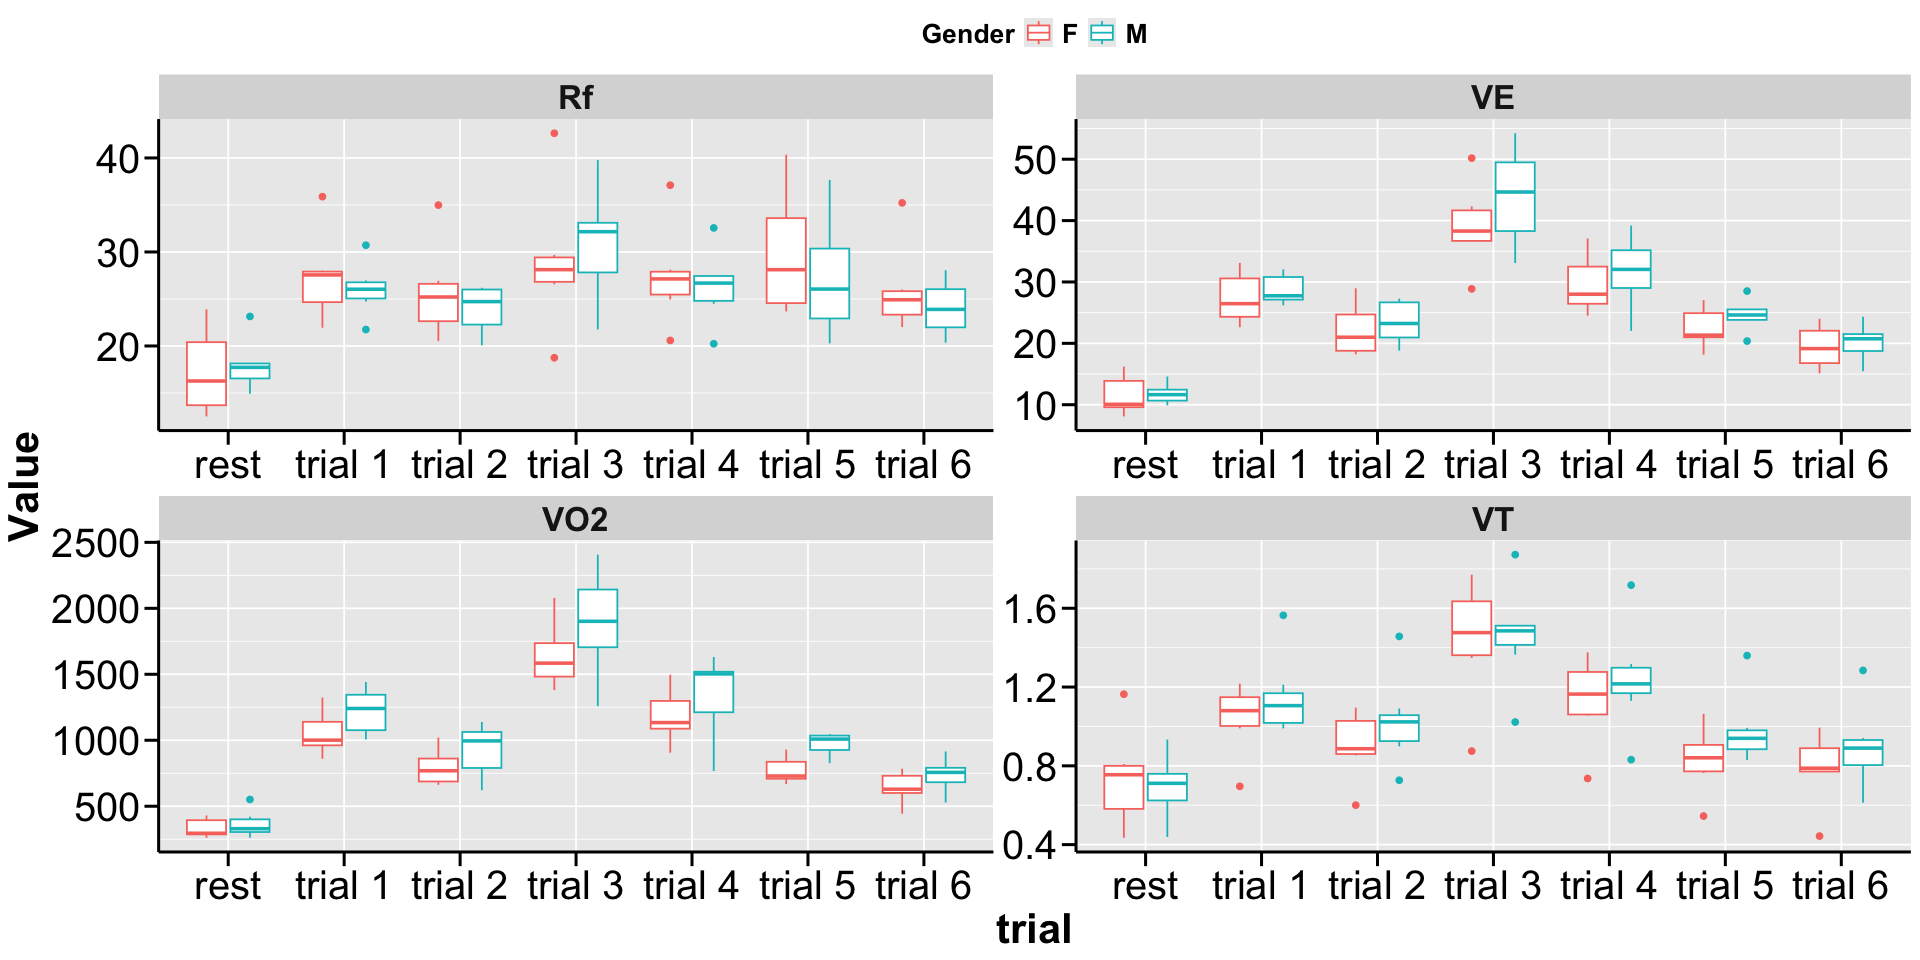

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 8)
ggplot(demo.data.var.long,aes(x=trial,Value,color=Gender))+
  geom_boxplot()+
  facet_wrap(~Variable,scales = "free") + thm

## The End